# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=180.18849314523848, mobile=False), User(purchased=True, time_on_site=135.67700482149365, mobile=False), User(purchased=True, time_on_site=159.88535379510446, mobile=True), User(purchased=True, time_on_site=257.7835981679507, mobile=True), User(purchased=False, time_on_site=86.99445445027507, mobile=False), User(purchased=False, time_on_site=173.67358829592212, mobile=True), User(purchased=True, time_on_site=44.968058188901246, mobile=True), User(purchased=False, time_on_site=30.15219480121866, mobile=True), User(purchased=False, time_on_site=460.0007745853941, mobile=False), User(purchased=False, time_on_site=122.22911474525455, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,180.188493,False
1,True,135.677005,False
2,True,159.885354,True
3,True,257.783598,True
4,False,86.994454,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.395806383057993,5.457727420381445,6.012980358659168,6.370819673044487,6.526220869482321,6.618506115477453,6.744300972093091,6.937814523764514,7.022230321283178,7.738183255456649,...,570.7205763776294,572.579212329361,573.071762294419,577.5607756708825,578.0265919014007,578.8349054472059,584.0914381586123,586.960469433746,588.7975083689481,599.8083961016524
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
True,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

# 5 equal-sized bins
time_bins = pd.cut(user_data['time_on_site'], 5)
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,240,233,105,29,28
True,96,131,102,20,16


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,0.714286,0.64011,0.507246,0.591837,0.636364
True,0.285714,0.35989,0.492754,0.408163,0.363636


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
persons_df = pd.read_csv("https://raw.githubusercontent.com/livjab/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv")
persons_df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
#setting some bins to make the data more managable

time_bins = pd.cut(persons_df['exercise_time'], 5)
age_bins = pd.cut(persons_df['age'], 8)
weight_bins = pd.cut(persons_df['weight'], 10)

In [31]:
# looking at relationship between age and exercise time

age_time_ct = pd.crosstab(age_bins, time_bins)
print(age_time_ct)

exercise_time    (-0.3, 60.0]  (60.0, 120.0]  (120.0, 180.0]  (180.0, 240.0]  \
age                                                                            
(17.938, 25.75]            26             34              36              38   
(25.75, 33.5]              38             22              32              35   
(33.5, 41.25]              40             45              26              34   
(41.25, 49.0]              22             24              20              19   
(49.0, 56.75]              19             23              25              20   
(56.75, 64.5]              29             45              27              33   
(64.5, 72.25]              47             61              42              13   
(72.25, 80.0]              57             62              15               0   

exercise_time    (240.0, 300.0]  
age                              
(17.938, 25.75]              20  
(25.75, 33.5]                40  
(33.5, 41.25]                35  
(41.25, 49.0]                

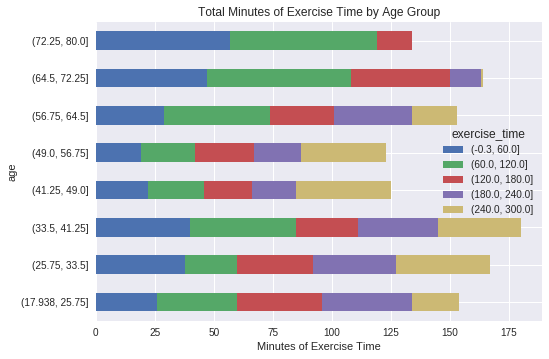

In [58]:
ax = age_time_ct.plot(kind='barh', stacked=True)

ax.set_title("Total Minutes of Exercise Time by Age Group")
ax.set_xlabel("Minutes of Exercise Time")

plt.show()

In [63]:
# looking at relationship betwen weight and exercise time

weight_time_ct = pd.crosstab(weight_bins, time_bins)
print(weight_time_ct)

exercise_time    (-0.3, 60.0]  (60.0, 120.0]  (120.0, 180.0]  (180.0, 240.0]  \
weight                                                                         
(99.854, 114.6]            27             28              41              38   
(114.6, 129.2]             26             37              30              41   
(129.2, 143.8]             21             32              32              39   
(143.8, 158.4]             23             44              35              35   
(158.4, 173.0]             31             47              28              25   
(173.0, 187.6]             30             46              28              13   
(187.6, 202.2]             30             31              27               1   
(202.2, 216.8]             46             42               2               0   
(216.8, 231.4]             28              9               0               0   
(231.4, 246.0]             16              0               0               0   

exercise_time    (240.0, 300.0]  
weigh

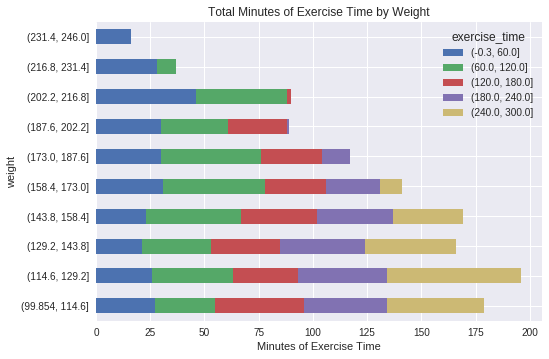

In [60]:
ax1 = weight_time_ct.plot(kind='barh', stacked=True)

ax1.set_title("Total Minutes of Exercise Time by Weight")
ax1.set_xlabel("Minutes of Exercise Time")

plt.show()

In [66]:
# looking at relationship between weight and age

weight_age_ct = pd.crosstab(age_bins, weight_bins)
print(weight_age_ct)

weight           (99.854, 114.6]  (114.6, 129.2]  (129.2, 143.8]  \
age                                                                
(17.938, 25.75]               22              26              22   
(25.75, 33.5]                 28              28              26   
(33.5, 41.25]                 36              40              21   
(41.25, 49.0]                 16              23              25   
(49.0, 56.75]                 20              26              14   
(56.75, 64.5]                 19              21              23   
(64.5, 72.25]                 21              18              22   
(72.25, 80.0]                 17              14              13   

weight           (143.8, 158.4]  (158.4, 173.0]  (173.0, 187.6]  \
age                                                               
(17.938, 25.75]              27              20              11   
(25.75, 33.5]                26              23              13   
(33.5, 41.25]                24              11    

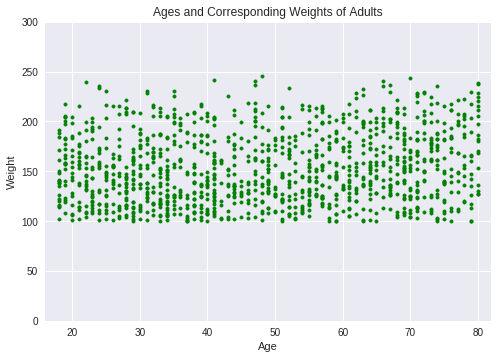

In [95]:
# using a scatter plot here because there seemed to be no pattern
# when trying bar plots.

plt.scatter(x=persons_df["age"], y=persons_df["weight"], marker='.', color='g')

plt.title("Ages and Corresponding Weights of Adults")
plt.xlabel("Age")
plt.ylabel("Weight")

plt.xlim([16,82])
plt.ylim([0,300])

plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)